# Import Libraries and Download NLTK Data
This section imports the necessary libraries and downloads the punkt tokenizer and stopwords from NLTK.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
import nltk
from collections import Counter
from nltk.tokenize import word_tokenize

# Download NLTK data
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Error loading stopwords: <urlopen error [WinError 10054]
[nltk_data]     An existing connection was forcibly closed by the
[nltk_data]     remote host>
[nltk_data] Error loading punkt: <urlopen error [WinError 10054] An
[nltk_data]     existing connection was forcibly closed by the remote
[nltk_data]     host>


False

# Load and Explore Dataset
This section loads the dataset from the JSON file and explores its basic structure.

In [2]:
# Load the dataset
df = pd.read_json('News_Category_Dataset_v3.json', lines=True)

# Display the first few rows of the dataset
print(df.head())

# Display basic information about the dataset
print(df.info())

# Display the count of articles in each category
print(df['category'].value_counts())


                                                link  \
0  https://www.huffpost.com/entry/covid-boosters-...   
1  https://www.huffpost.com/entry/american-airlin...   
2  https://www.huffpost.com/entry/funniest-tweets...   
3  https://www.huffpost.com/entry/funniest-parent...   
4  https://www.huffpost.com/entry/amy-cooper-lose...   

                                            headline   category  \
0  Over 4 Million Americans Roll Up Sleeves For O...  U.S. NEWS   
1  American Airlines Flyer Charged, Banned For Li...  U.S. NEWS   
2  23 Of The Funniest Tweets About Cats And Dogs ...     COMEDY   
3  The Funniest Tweets From Parents This Week (Se...  PARENTING   
4  Woman Who Called Cops On Black Bird-Watcher Lo...  U.S. NEWS   

                                   short_description               authors  \
0  Health experts said it is too early to predict...  Carla K. Johnson, AP   
1  He was subdued by passengers and crew when he ...        Mary Papenfuss   
2  "Until you have a dog y

# Generate Word Cloud for Important Parts
This section generates a word cloud for the combined headlines to visualize the most common words.

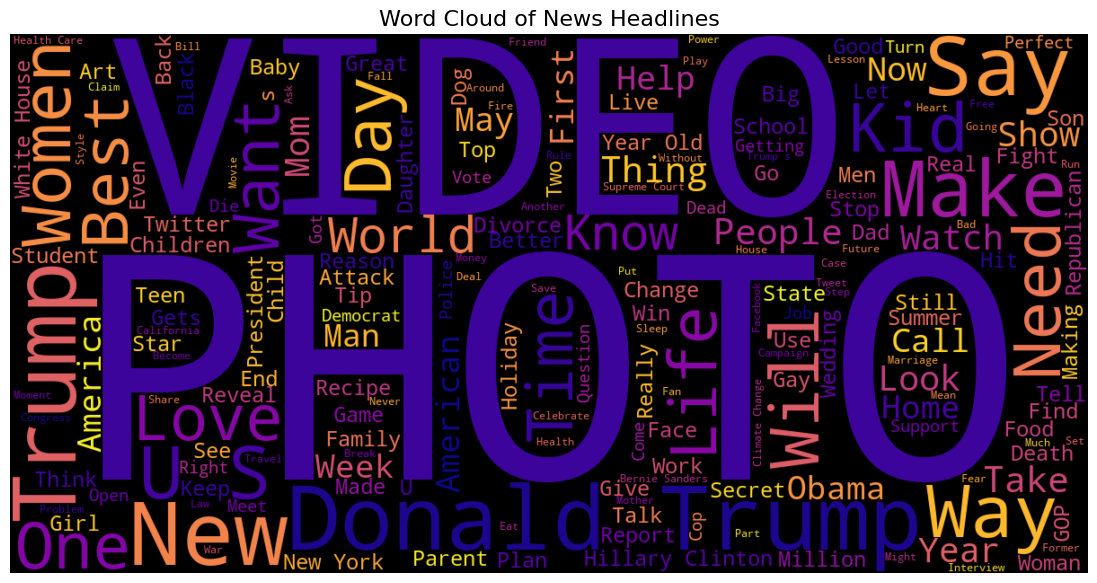

In [3]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Enhanced function to generate a word cloud with customization
def generate_word_cloud(text):
    # Define a set of custom stopwords
    custom_stopwords = set(STOPWORDS)
    custom_stopwords.update([
        'the', 'and', 'a', 'to', 'of', 'in', 'for', 'on', 'is', 'that', 'with', 'as', 'at', 'by', 'an', 'be', 'from', 'or'
    ])
    
    # Create a word cloud with customizations
    wordcloud = WordCloud(
        width=1200,
        height=600,
        background_color='black',
        colormap='plasma',  # Cool color map
        contour_color='black',  # Outline color for words
        contour_width=1,
        stopwords=custom_stopwords,
        random_state=42
    ).generate(text)

    # Display the word cloud
    plt.figure(figsize=(14, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Remove axis
    plt.title('Word Cloud of News Headlines', fontsize=16, color='black')  # Add title
    plt.show()

# Combine all headlines into a single text
text = ' '.join(df['headline'])

# Generate and display the enhanced word cloud
generate_word_cloud(text)



# Calculate Word Frequency in Each Category
This section calculates the word frequency for each category in the dataset.

In [4]:
# Initialize a dictionary to store word counts for each category
category_word_counts = {}

# Tokenize headlines and count words for each category
for category in df['category'].unique():
    category_data = df[df['category'] == category]
    words = word_tokenize(' '.join(category_data['headline']).lower())
    words = [word for word in words if word.isalnum()]
    word_count = Counter(words)
    category_word_counts[category] = word_count

# Display the most common words in the 'POLITICS' category
print(category_word_counts['POLITICS'].most_common(10))


[('to', 10713), ('trump', 9771), ('the', 9635), ('of', 5552), ('in', 5273), ('for', 4935), ('a', 4777), ('on', 4138), ('is', 3363), ('donald', 3113)]


# Keep Only the Top 10 Categories
This section filters the dataset to keep only the top 10 categories based on the number of articles.

In [5]:
# Identify the top 10 categories by article count
top_categories = df['category'].value_counts().nlargest(10).index

# Filter the dataset to keep only the top 10 categories
df = df[df['category'].isin(top_categories)]

# Display the count of articles in the top 10 categories
print(df['category'].value_counts())


category
POLITICS          35602
WELLNESS          17945
ENTERTAINMENT     17362
TRAVEL             9900
STYLE & BEAUTY     9814
PARENTING          8791
HEALTHY LIVING     6694
QUEER VOICES       6347
FOOD & DRINK       6340
BUSINESS           5992
Name: count, dtype: int64


# Clean Text by Removing Stop Words
This section cleans the text by removing stop words from the headlines.

In [6]:
# Define a set of stop words
stop_words = set(stopwords.words('english'))

# Function to clean text by removing stop words
def clean_text(text):
    words = word_tokenize(text.lower())
    words = [word for word in words if word.isalnum() and word not in stop_words]
    return ' '.join(words)

# Apply the cleaning function to the headlines
df['cleaned_headline'] = df['headline'].apply(clean_text)


# Create Dictionaries for Each Category
This section creates dictionaries to hold word counts for each category after cleaning the text.

In [7]:
# Initialize a dictionary to store word counts for each category
category_word_counts = {}

# Tokenize cleaned headlines and count words for each category
for category in df['category'].unique():
    category_data = df[df['category'] == category]
    words = word_tokenize(' '.join(category_data['cleaned_headline']))
    word_count = Counter(words)
    category_word_counts[category] = word_count

# Display the most common words in the 'POLITICS' category
print(category_word_counts['POLITICS'].most_common(10))


[('trump', 9771), ('donald', 3113), ('gop', 1901), ('clinton', 1739), ('obama', 1652), ('says', 1474), ('new', 1362), ('house', 1327), ('hillary', 1297), ('white', 953)]


# Categorize Words
This section counts the words in each document, categorizing them in the dictionaries.

In [8]:
# Function to categorize words and count them for each category
def categorize_words(text, category_word_counts):
    words = word_tokenize(text)
    category_counts = {category: 0 for category in category_word_counts.keys()}
    
    for word in words:
        for category, word_count in category_word_counts.items():
            if word in word_count:
                category_counts[category] += word_count[word]
                
    return category_counts

# Apply the categorization function to the cleaned headlines
df['category_counts'] = df['cleaned_headline'].apply(lambda x: categorize_words(x, category_word_counts))


# Assign Class (Predict)
This section predicts the category of each document based on the word counts and evaluates the prediction accuracy.

In [9]:
# Function to predict the category based on word counts
def predict_category(counts):
    return max(counts, key=counts.get)

# Apply the prediction function to the categorized word counts
df['predicted_category'] = df['category_counts'].apply(predict_category)

# Evaluate the prediction accuracy
accuracy = (df['category'] == df['predicted_category']).mean()
print(f'Prediction accuracy: {accuracy:.2f}')


Prediction accuracy: 0.58
